# Introduction

In this notebook we will create a number of models to predict the distance between two sensors(?) based on the RSSI strength of a Wifi signal sent between them. 

Let's load relevant libraries.

In [0]:
import numpy as np
import csv
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Data

Let's load the data and take a look. Be sure to mount your drive (hit the icon on the left that looks like a folder and then click 'Mount Drive'). Update the below variable to be the path to the directory with this notebook in your drive.

In [0]:
root_path = "drive/My Drive/family_favors/nader/"

In [3]:
with open(root_path+'logDistance_vs_RSSI.csv', newline='') as file:
  reader = csv.reader(file)
  logDists = []
  RSSIs = []
  # we need to skip the first line since it is just the column labels
  readingFirstLine = True
  # this is just to demonstrate how the rows are read in (for learning purposes)
  readingFirstDataLine = True
  for row in reader:
    if readingFirstLine:
      readingFirstLine = False
      continue
    elif readingFirstDataLine:
      print('Take a look at what our csv reader reads in for each row:')
      print(row)
      readingFirstDataLine = False
    # each row is a list with two entries: logDist and RSSI
    # the entries are wrapped in strings however, so we will need to cast them
    logDist, RSSI = [np.float(entry) for entry in row]
    logDists.append(logDist)
    RSSIs.append(RSSI)


Take a look at what our csv reader reads in for each row:
['1.183391906', '-84']


Great, now we have our data, and we can take a quick look at it with matplotlib.pyplot, a python library for plotting. 

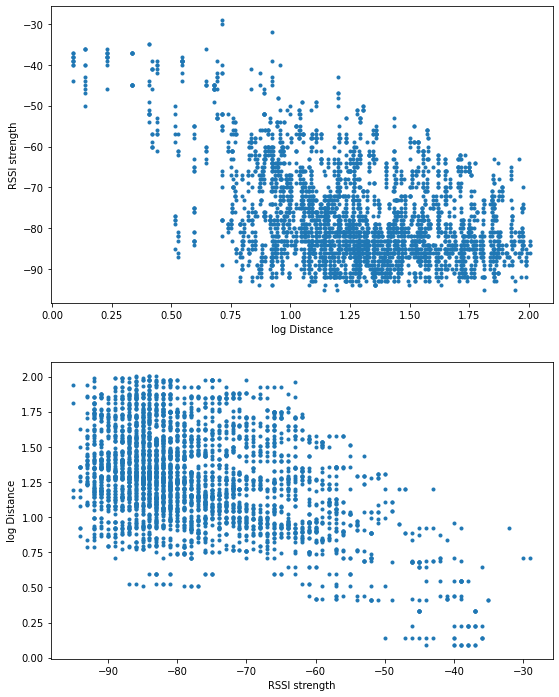

In [4]:
plt.figure(figsize=(9,12))
plt.subplot(211)
plt.plot(logDists, RSSIs, '.')
plt.xlabel('log Distance')
plt.ylabel('RSSI strength')
plt.subplot(212)
plt.plot(RSSIs, logDists, '.')
plt.ylabel('log Distance')
plt.xlabel('RSSI strength')
plt.show()

I've recreated the original plot I was shown above, as well as a plot with the axis swapped (which makes more sense to me since I was under the impression that RSSI strength is our independent variable). 

In all honesty, I think this data is very noisy and nothing will have a great fit. But alas, we will try.

We can introduce some handcrafted features that will maybe help, but I doubt it.

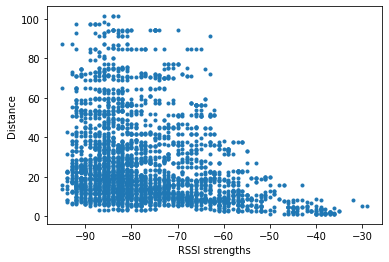

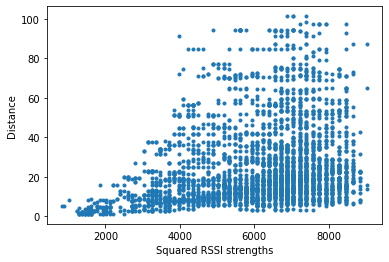

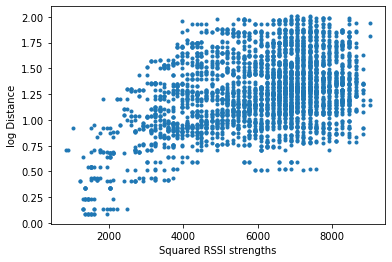

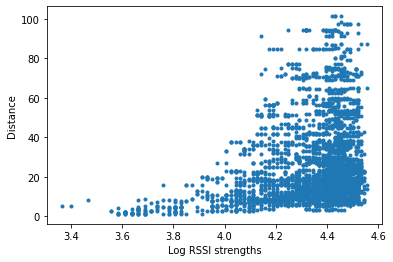

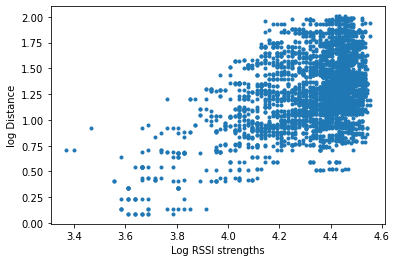

In [5]:
def display(x, y, x_label, y_label):
  plt.plot(x, y, '.')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()


dists = [10**x for x in logDists]
sq_strengths = [x**2 for x in RSSIs]
log_strengths = np.log(-1 * np.array(RSSIs))
display(RSSIs, dists, 'RSSI strengths', 'Distance')
display(sq_strengths, dists, 'Squared RSSI strengths', 'Distance')
display(sq_strengths, logDists, 'Squared RSSI strengths', 'log Distance')
display(log_strengths, dists, 'Log RSSI strengths', 'Distance')
display(log_strengths, logDists, 'Log RSSI strengths', 'log Distance')

I'm still not very happy with any of these, mainly because of the collinearity of the data. There is such a wide range of distances for each RSSI strength that suggests RSSI alone will not suffice in determining a match. 

However, the data is a little silly, since we are looking at very long distances. Let's have another dataset that only considers data points that were within ten meters of the source. This is more relevant to the application of contact tracing, and it will give any fitting a better chance, as we will remove much of the collinearity. Let's take a look.

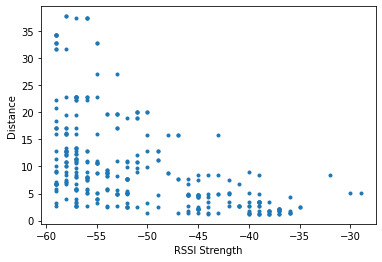

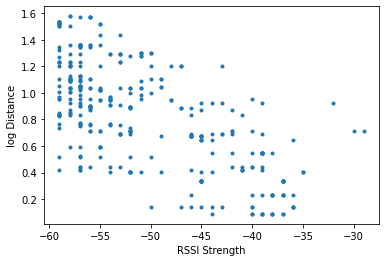

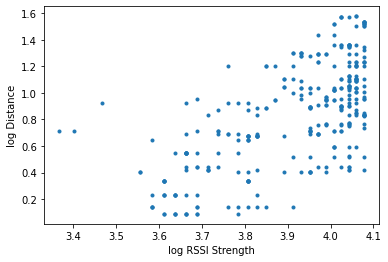

In [6]:
closer_pts_indices = np.where(np.array(RSSIs)>-60)[0]
close_dists = np.take(dists, closer_pts_indices)
close_RSSIs = np.take(RSSIs, closer_pts_indices)
display(close_RSSIs, close_dists, 'RSSI Strength', 'Distance')
close_log_dists = np.log10(close_dists)
close_sq_RSSIs = [x**2 for x in close_RSSIs]
close_log_RSSIs = np.log(-1 * close_RSSIs)
display(close_RSSIs, close_log_dists, 'RSSI Strength', 'log Distance')
display(close_log_RSSIs, close_log_dists, 'log RSSI Strength', 'log Distance')

Ok, well we have our data and in a bunch of different ways. Let's move on to building models.

# Parametric Curve Fitting

An elementary approach would be to make a guess as to what our fit function should be, and optimize the parameters for that function based on our training data. Scipy has a tool to do this for us - yay!

In [0]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import scipy

def line(x, a, b):
  return a * x + b

def sqrt(x, a, b, c, d):
  return a * np.sqrt(b * np.abs(x-d)) + c

def arctangent(x, a, b, c, d):
  return a * np.arctan(x * b + d) + c

def power(x, a, b, c, d):
  return a * np.power(b, x - c) + d

In [0]:
def fit_a_function(f, inputs=RSSIs, outputs=dists, log_outputs = logDists):
  popt1, _ = curve_fit(f, inputs, outputs, maxfev=100000)
  x = np.linspace(np.min(inputs), np.max(inputs))
  plt.plot(x, f(x, *popt1))
  display(inputs, outputs, 'RSSI Strengths', 'Distances')
  print('MSE: ', mean_squared_error(outputs, f(np.array(inputs), *popt1)))
  popt2, _ = curve_fit(f, inputs, log_outputs, maxfev=100000)
  plt.plot(x, f(x, *popt2))
  display(inputs, log_outputs, 'RSSI Strengths', 'logDistances')
  print('MSE: ', mean_squared_error(log_outputs, f(np.array(inputs), *popt2)))


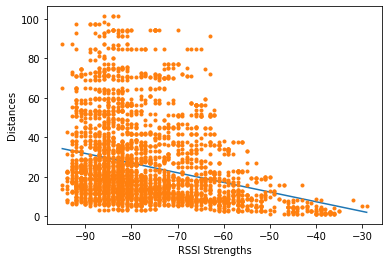

MSE:  380.31619971877257


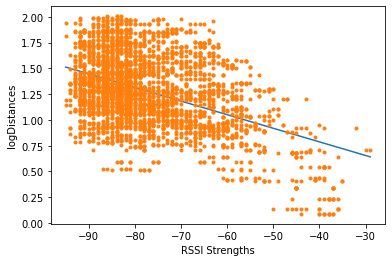

MSE:  0.09958467852348728


In [17]:
fit_a_function(line)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


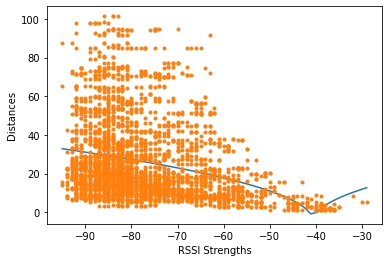

MSE:  378.7178465032517


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


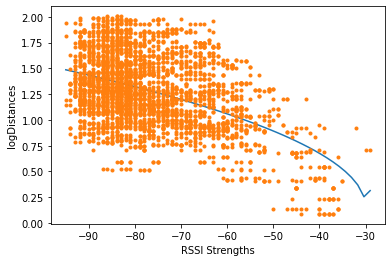

MSE:  0.09702153405165716


In [18]:
fit_a_function(sqrt)

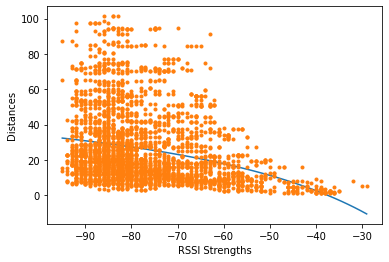

MSE:  378.6407918920163


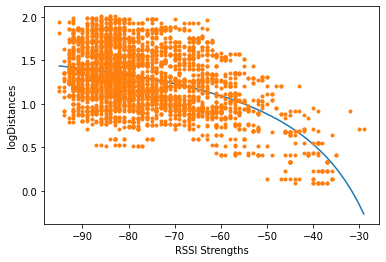

MSE:  0.09496319064505278


In [19]:
fit_a_function(arctangent)

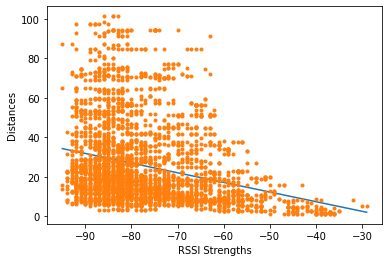

MSE:  380.326032453588


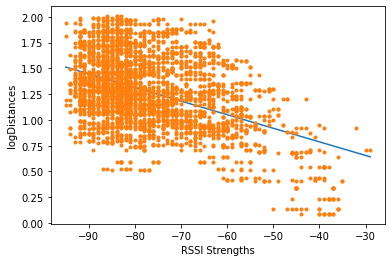

MSE:  0.09958943880197445


In [20]:
fit_a_function(power)

I don't know if we can get anything much better than this.

## Clipped Data

Let's see if the fits are better for the clipped data.

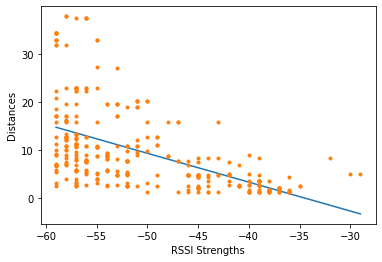

MSE:  51.79575944987255


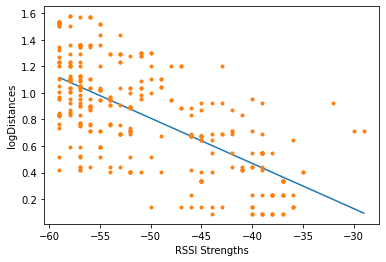

MSE:  0.08312296544494152


In [21]:
# print(len(close_log_dists), len(dists))
fit_a_function(line, inputs=close_RSSIs, outputs=close_dists, log_outputs=close_log_dists)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


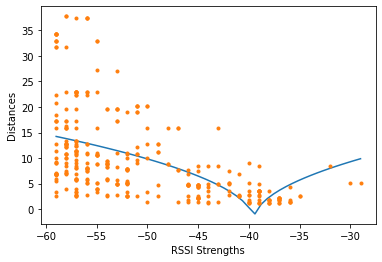

MSE:  52.461785156565206


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


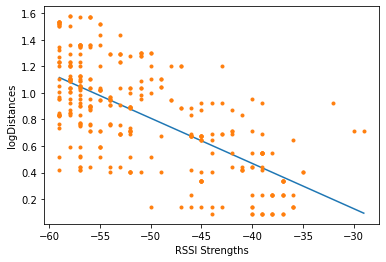

MSE:  0.083125532159198


In [22]:
fit_a_function(sqrt, inputs=close_RSSIs, outputs=close_dists, log_outputs=close_log_dists)

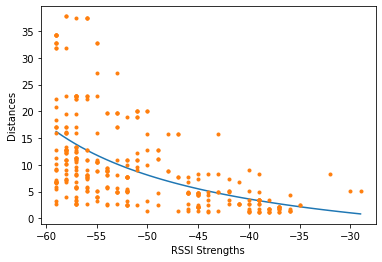

MSE:  50.87438971252708


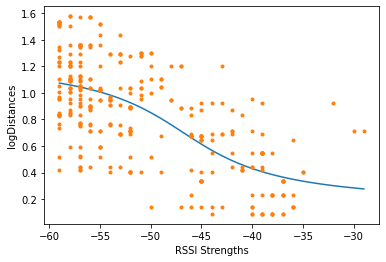

MSE:  0.08172547181872461


In [23]:
fit_a_function(arctangent, inputs=close_RSSIs, outputs=close_dists, log_outputs=close_log_dists)

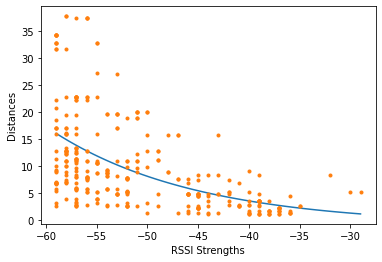

MSE:  50.88082626673551


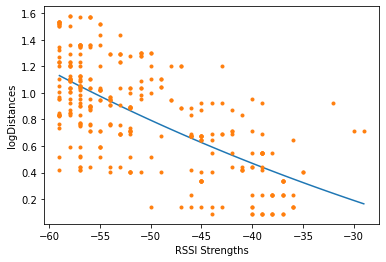

MSE:  0.08293600906045834


In [24]:
fit_a_function(power, inputs=close_RSSIs, outputs=close_dists, log_outputs=close_log_dists)

Better than before, but in my opinion, still pretty bad. 

# Method 2 - Neural Network

I think our issue is with the data and its not going to get much better no matter what we do. But, alas, we will trudge forward and just throw this data at a neural network.

Let's define a simple network - only fully connected layers. 

In [113]:
class Net(nn.Module):

    def __init__(self, input_dim):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 6)
        self.fc4 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net(3)
print(net)

Net(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)


Let's make tensors for our input data. I'm going to stack the squared RSSI strength and the log RSSI strength just so we have a little more to work with, but I doubt that will help much. 

In [76]:
RSSI_features = np.vstack((np.array(RSSIs), np.array(sq_strengths), np.array(log_strengths))).T
print(RSSI_features.shape)
input_tensorO = torch.tensor(RSSI_features)
output_tensorO = torch.tensor(np.array(dists))
datasetO = data.TensorDataset(input_tensor, output_tensor)
loaderO = data.DataLoader(dataset, batch_size=50)

(3547, 3)


Now let's write some boiler plate training code.

In [0]:
def train_and_display(x_np_arr, y_np_arr, batch_size=50, rate=0.0005, num_epochs=150):
  ''' x_np_arr and y_np_arr are the inputs and outputs of our training data
      respectively. Each should be numpy arrays and have M rows, where M is
      the number of samples in the training set.
      
      For display purposes, make sure RSSI strength is always in the first column
      of x_np_arr (column 0). '''

  # prepare necessary pytorch objects: TensorDatset, Loader
  in_tensor = torch.tensor(x_np_arr)
  out_tensor = torch.tensor(y_np_arr)
  dataset = data.TensorDataset(in_tensor, out_tensor)
  loader = data.DataLoader(dataset, batch_size)
  
  # initialize model - size of first layer is determined by length of feature 
  # vector of our inputs (given by first dimension of input array)
  input_dim = x_np_arr.shape[1]
  model = Net(input_dim)
  # let's train on everything since thats what curve fitting did
  model.train()
  criterion = F.mse_loss
  optimizer = torch.optim.Adam(model.parameters(), lr=rate)

  for epoch in range(num_epochs):
    epoch_loss = 0
    ctr = 0
    for inputs, labels in loader:
      optimizer.zero_grad()
      model.zero_grad()
      outputs = model(inputs.float())
      loss = criterion(labels.view(-1,1), outputs)
      loss.backward()
      optimizer.step()
      # epoch_loss turns out to be the sum of all squared errors (MSE * num_samples)
      epoch_loss += loss.item() * inputs.size(0)
      ctr += inputs.size(0)
    # we divide by total number of samples to get MSE again
    avg_loss = epoch_loss / ctr
    if (epoch+1) % 10 == 0 or epoch == 0:
      print('Epoch: {}........MSE: {:.8f}'.format(epoch+1, avg_loss))

  # let's display our fit
  all_outputs = model(in_tensor.float())
  preds = all_outputs.detach().numpy() # makes numpy array from output tensor
  plt.plot(x_np_arr[:,0], preds, 'o')
  plt.plot(x_np_arr[:,0], y_np_arr, '.')
  plt.show()

  return model

Epoch: 1........MSE: 518.62136302
Epoch: 10........MSE: 398.65786232
Epoch: 20........MSE: 397.53328918
Epoch: 30........MSE: 395.40290592
Epoch: 40........MSE: 393.74405866
Epoch: 50........MSE: 393.79565017
Epoch: 60........MSE: 391.69344173
Epoch: 70........MSE: 391.21053168
Epoch: 80........MSE: 390.72378618
Epoch: 90........MSE: 390.52594416
Epoch: 100........MSE: 390.20450597
Epoch: 110........MSE: 390.04276140
Epoch: 120........MSE: 389.88471377
Epoch: 130........MSE: 389.72520321
Epoch: 140........MSE: 389.56497876
Epoch: 150........MSE: 389.40498233


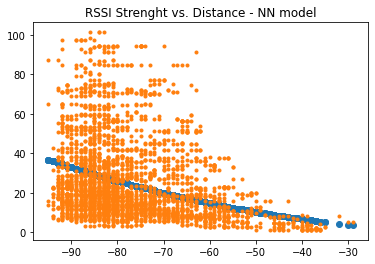

In [118]:
plt.title('RSSI Strenght vs. Distance - NN model')
all_data_nn = train_and_display(RSSI_features, np.array(dists))

Epoch: 1........MSE: 24514.63845752
Epoch: 10........MSE: 8.17676412
Epoch: 20........MSE: 0.11033886
Epoch: 30........MSE: 0.11041205
Epoch: 40........MSE: 0.11052081
Epoch: 50........MSE: 0.11068035
Epoch: 60........MSE: 0.11092472
Epoch: 70........MSE: 0.11130200
Epoch: 80........MSE: 0.11190285
Epoch: 90........MSE: 0.11291841
Epoch: 100........MSE: 0.11414439
Epoch: 110........MSE: 0.11402496
Epoch: 120........MSE: 0.11406329
Epoch: 130........MSE: 0.11316508
Epoch: 140........MSE: 0.11074871
Epoch: 150........MSE: 0.11075665


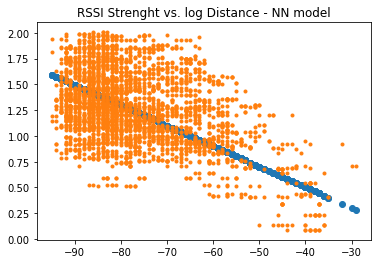

In [125]:
plt.title('RSSI Strenght vs. log Distance - NN model')
data_nn = train_and_display(RSSI_features, np.array(logDists), rate=0.0001)

## Clipped Data

Let's prep the input features in the same way.

In [0]:
close_RSSI_features = np.vstack((np.array(close_RSSIs), np.array(close_sq_RSSIs), np.array(close_log_RSSIs))).T

Epoch: 1........MSE: 55.85001171
Epoch: 10........MSE: 57.25950566
Epoch: 20........MSE: 57.11938727
Epoch: 30........MSE: 56.97384608
Epoch: 40........MSE: 56.83432632
Epoch: 50........MSE: 56.70134159
Epoch: 60........MSE: 56.57446319
Epoch: 70........MSE: 56.45306525
Epoch: 80........MSE: 56.33656184
Epoch: 90........MSE: 56.22444468
Epoch: 100........MSE: 56.11638994
Epoch: 110........MSE: 56.01228651
Epoch: 120........MSE: 55.91230898
Epoch: 130........MSE: 55.81673564
Epoch: 140........MSE: 55.72570669
Epoch: 150........MSE: 55.63909859


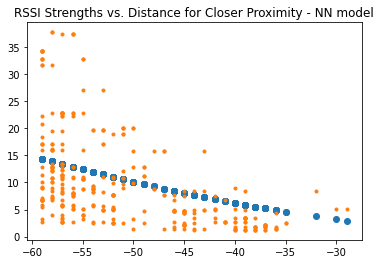

In [135]:
plt.title('RSSI Strengths vs. Distance for Closer Proximity - NN model')
data_nn = train_and_display(close_RSSI_features, np.array(close_dists), batch_size=20)

Epoch: 1........MSE: 4737.23153635
Epoch: 10........MSE: 3489.41129683
Epoch: 20........MSE: 2429.54803651
Epoch: 30........MSE: 1643.31623714
Epoch: 40........MSE: 1071.00618321
Epoch: 50........MSE: 665.75566097
Epoch: 60........MSE: 389.71808434
Epoch: 70........MSE: 211.43359861
Epoch: 80........MSE: 104.23836437
Epoch: 90........MSE: 45.60579922
Epoch: 100........MSE: 17.23573416
Epoch: 110........MSE: 5.48341816
Epoch: 120........MSE: 1.46692127
Epoch: 130........MSE: 0.37842571
Epoch: 140........MSE: 0.15361084
Epoch: 150........MSE: 0.11996546


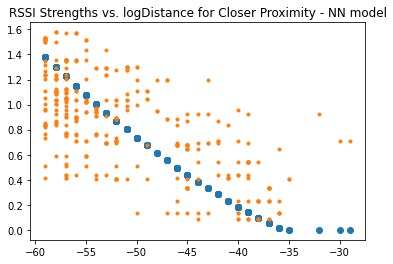

In [144]:
plt.title('RSSI Strengths vs. logDistance for Closer Proximity - NN model')
data_nn = train_and_display(close_RSSI_features, np.array(close_log_dists), batch_size=10, rate=0.00001)

Neural networks were more complicated and nondeterministic in training behavior - they often required many attempts. The results are just about the same as before. I maintain though that this is likely an artifact of the data.

# A Lower Bound of Performance for our data

I've been complaining about this data throughout this entire notebook. Let's put our results in perspective to see what the lowest possible MSE would be if we completely cheat. That is, we just take the mean distance for each RSSI strength value in our dataset. We can do this because the RSSI strengths come in discrete values.

We first get all unique RSSI strengths measured with the command 'set'. We then loop through each of these unique instances and find all measurements that had that strength. We can then take the mean of those distances to find the prediction that would minimize mean squared error.

In [0]:
def lower_bound(RSSI_vals, dist_vals, log_dist_vals):
  ''' i've generalized this function so we can reuse it for our entire data
      and also for our 'close-proximity' set  '''
  strengths = list(set(RSSI_vals))
  mean_dists = []
  mean_log_dists = []
  sq_error = 0
  sq_error_for_log = 0
  for strength in strengths:
    instances = np.where(np.array(RSSI_vals) == strength)[0]
    dists_for_strength = np.take(np.array(dist_vals), instances)
    mean_dist = np.mean(dists_for_strength)
    sq_error += sum([(x-mean_dist)**2 for x in dists_for_strength])
    mean_dists.append(mean_dist)
    # same thing for log dists
    log_dists_for_strength = np.take(np.array(log_dist_vals), instances)
    mean_log_dist = np.mean(log_dists_for_strength)
    sq_error_for_log += sum([(x-mean_log_dist)**2 for x in log_dists_for_strength])
    mean_log_dists.append(mean_log_dist)

  plt.plot(RSSI_vals, dist_vals, '.')
  plt.plot(strengths, mean_dists, 'o')
  plt.ylabel('Distances')
  print('Lowest Possible MSE: {}'.format(sq_error/len(RSSI_vals)))
  plt.show()

  plt.plot(RSSI_vals, log_dist_vals, '.')
  plt.plot(strengths, mean_log_dists, 'o')
  plt.ylabel('Log Distances')
  print('Lowest Possible MSE: {}'.format(sq_error_for_log/len(RSSI_vals)))
  plt.show()

ALL DATA
Lowest Possible MSE: 370.18309150114544


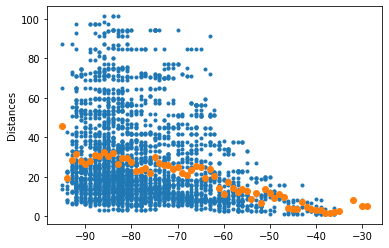

Lowest Possible MSE: 0.09102729037904833


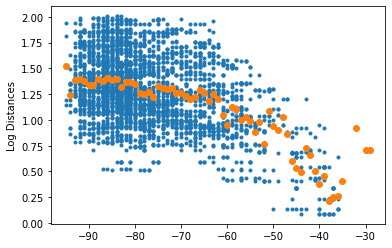

In [168]:
print('ALL DATA')
lower_bound(RSSIs, dists, logDists)

CLOSE DATA
Lowest Possible MSE: 47.31671627870481


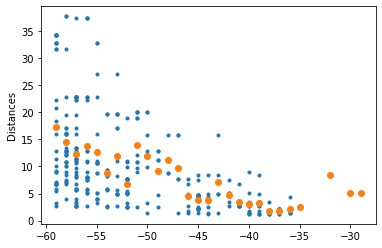

Lowest Possible MSE: 0.07091528962688258


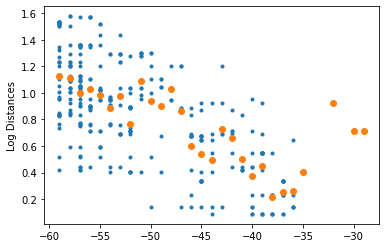

In [169]:
print('CLOSE DATA')
lower_bound(close_RSSIs, close_dists, close_log_dists)

OK! Now we can put our previous results into context. Our fits don't seem to bad relative to the optimal fit, as we often get within 5% of the optimal MSE. 